# Capstone Demonstration, Bayesian AB Testing

Now that we understand the fundamentals of bayesian statistics. Let's figure out how we might use the results of an AB test to draw meaningful conclusions.


First, we should create two distributions that will represent the results from our test. 

## Import Packages and Data w/ subsequent Quick Clean

In [1]:
import calc_prob  # Special thanks to @vlavorini for this package
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from scipy.stats import beta

# Make it beautiful
plt.style.use("seaborn")
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def create_beta_prams(df):
    
    # Get conversions
    conversions = df.groupby("converted")["converted"].count()
    
    # Get successess and total trials
    n = conversions.sum()
    y_i = conversions[1]
    
    # Create beta distribution
    alpha = y_i + 1
    beta = n - y_i + 1
    
    return alpha, beta

We will create the distributions from real data for fun

In [3]:
# Import Data
dat_url = "https://raw.githubusercontent.com/SThornewillvE/Udacity-DataAnalyst-Nanodegree/master/05-ab-test-2_project/ab_data.csv"
response = requests.get(dat_url).content
df = pd.read_csv(io.StringIO(response.decode('utf-8')))

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# Get rid of bad data
df_control = df[(df["group"] == "control") & (df["landing_page"] == "old_page")].drop_duplicates()
df_treatment = df[(df["group"] == "treatment") & (df["landing_page"] == "new_page")].drop_duplicates()

## Create Beta Distributions

We can use the function defined at the start of this notebook to calculate the parameters ($\alpha$, $\beta$) for the beta distributions used to describe the control and treatement conversion rates.

In [5]:
alpha_1, beta_1 = create_beta_prams(df_control)
alpha_2, beta_2 = create_beta_prams(df_treatment)

In [6]:
# Create beta dists
beta_ctrl = beta(alpha_1, beta_1)
beta_test = beta(alpha_2, beta_2)

## Plot beta distributions

Now that we have created the objects for the beta distributions, let's have a look at what they look like when they are plotted.

In [7]:
# Create vectors for plotting
X = np.linspace(0, 1, 20000)

y_cont = beta_ctrl.pdf(X)
y_treat = beta_test.pdf(X)

In [8]:
#Calculating the lift
lift=(beta_test.mean()-beta_ctrl.mean())/beta_ctrl.mean()

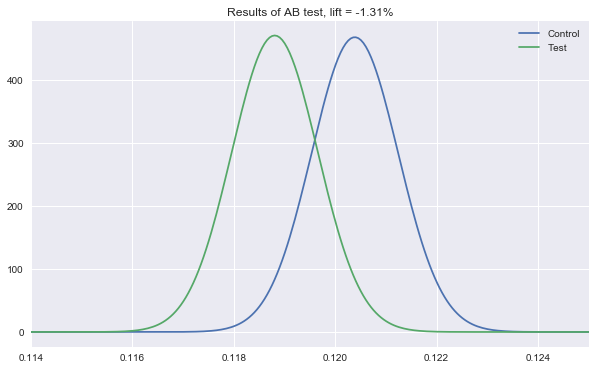

In [9]:
# Plot Data
fig, ax = plt.subplots(facecolor="white", edgecolor="k", figsize=(10, 6))
plt.plot(X, y_cont, label="Control")
plt.plot(X, y_treat, label="Test")
plt.xlim(0.114, 0.125)
plt.title("Results of AB test, lift = {}%".format(round(lift*100, 2)))
plt.legend()
plt.show()

We can wee that the test did a little worse. But what we want to know how is the probability of out test variant being better than the control variant.

We will worry about calcul

## What's the probability that our test did worse than the control?

In order to calculate this probability, we are going to simulate twenty thousand samples from beta distributions defined with the prameters above.

This will allow us to make two probability distributions which we can plot with a 2d contour style.

In [10]:
# Create simulated values
samples_ctrl = beta_ctrl.rvs(20_000)
samples_test = beta_test.rvs(20_000)

# Transform vectors into a dataframe for plotting
vals=np.vstack([samples_ctrl, samples_test]).T
df_results=pd.DataFrame(vals, columns=['Control', 'Test'])

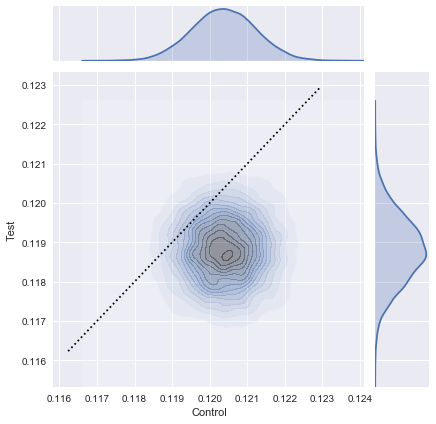

In [11]:
# Create a plot of one better than another
g=sns.jointplot(df_results.Control, df_results.Test, kind='kde', n_levels=15, alpha=0.4)

# Create equivalence line
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k') 

plt.show()

In [12]:
prob = calc_prob.calc_prob_between(beta_test, beta_ctrl)

print("___")
print("The probability of the test variant being better than control variant is {}%.".format(round(prob*100, 2)))
print("___")

___
The probability of the test variant being better than control variant is 9.48%.
___


## Conclusion

We can see there that it is relatively unlikely that our test variant is better than our control. Notice how instead of rejecting/failing reject a hypothesis, we can instead state the probability of one variant being better than the other, which is far easier to communicate with stakeholders.

The only disadvantage is that doing this calculation is less straight forward and takes a little bit of time to learn how to do. But once you've done it once, you have the code forever and you have a powerful tool for testing new variants.